# Sub-classes Chest XRay

In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%pdb on

Automatic pdb calling has been turned ON


In [18]:
from PIL import Image
print(Image.PILLOW_VERSION)
from PIL import features
print(features.features)

5.3.0.post0
{'webp_anim': ('PIL._webp', 'HAVE_WEBPANIM'), 'webp_mux': ('PIL._webp', 'HAVE_WEBPMUX'), 'transp_webp': ('PIL._webp', 'HAVE_TRANSPARENCY'), 'raqm': ('PIL._imagingft', 'HAVE_RAQM')}


In [19]:
from fastai.vision import *
from fastai.metrics import error_rate

In [20]:
from fastai.vision import transform

In [21]:
# batch size
bs = 64

In [22]:
path = Path('/data0/chest_xray/')

In [23]:
path_img = path/'train/'
path_img.ls()

[PosixPath('/data0/chest_xray/train/NORMAL'),
 PosixPath('/data0/chest_xray/train/PNEUMONIA')]

In [24]:
fnames = list(filter(
    lambda f: f.endswith('.jpeg'), 
    map(str, (path/'val/PNEUMONIA').ls())
))
fnames

['/data0/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg',
 '/data0/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
 '/data0/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg',
 '/data0/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg',
 '/data0/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg',
 '/data0/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg',
 '/data0/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
 '/data0/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg']

In [25]:
from PIL import Image
import re

for p in fnames:
    with Image.open(p) as img:
        print(p, img.size);

/data0/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg (1072, 712)
/data0/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg (1152, 664)
/data0/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg (1016, 656)
/data0/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg (1256, 864)
/data0/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg (1416, 944)
/data0/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg (1192, 952)
/data0/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg (1664, 1128)
/data0/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg (968, 592)


In [26]:
fre = re.compile(r'/(PNEUMONIA|NORMAL)/[a-zA-Z0-9]+[_-](bacteria|virus|IM)*.+\.jpeg')
def label_fn(fpath):
    m = fre.search(str(fpath))
    assert m is not None
    lbl = m.group(1)
    if lbl == "NORMAL":
        return "normal"
    else:
        return m.group(2)

display(
    label_fn("/data0/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg"),
    label_fn("/data0/chest_xray/train/PNEUMONIA/person365_virus_745.jpeg")
)

'normal'

'virus'

In [27]:
p_affine = 0.75
max_rotate = 10.
max_warp = 0.2
max_zoom = 1.1
p_lighting = 0.75
max_lighting:float = 0.2
                    
train_tfms = [
    transform.symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine),
    transform.rotate(degrees=(-max_rotate,max_rotate), p=p_affine),
    transform.rand_zoom(scale=(1.,max_zoom), p=p_affine),
    transform.brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting),
    transform.contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting),
]

tfms = (train_tfms, [])
display(tfms)

([RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [])

In [31]:
split_validation_by_pct = None
if split_validation_by_pct is not None:
    il = ImageList.from_folder(path)
    src = il.split_by_rand_pct(split_validation_by_pct)
    src.label_from_func(label_fn)
    data = ImageDataBunch.create_from_ll(src, size=224, ds_tfms=tfms)
else:
    il = ImageList.from_folder(path)
    src = il.split_by_folder(train='train', valid='val')
    src.label_from_func(label_fn)
    data = ImageDataBunch.create_from_ll(src, test='test', size=224, ds_tfms=tfms)    

In [32]:
data.classes

['bacteria', 'normal', 'virus']

In [33]:
data

ImageDataBunch;

Train: LabelList (5216 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,normal
Path: /data0/chest_xray;

Valid: LabelList (16 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,normal
Path: /data0/chest_xray;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /data0/chest_xray

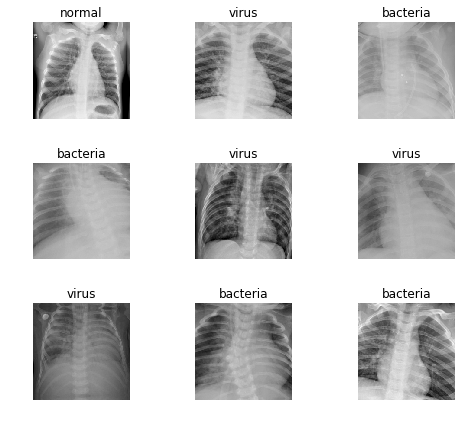

In [35]:
data.show_batch(rows=3, figsize=(7,6))

In [36]:
print(data.classes)
len(data.classes),data.c

['bacteria', 'normal', 'virus']


(3, 3)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [48]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

/home/denis/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [49]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [50]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.712098,0.834579,0.562500,00:57
1,0.572655,0.973286,0.437500,00:57
2,0.519042,0.903309,0.437500,00:57
3,0.467748,0.937372,0.437500,00:56


In [51]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [53]:
display(data.valid_ds)

LabelList (16 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,normal
Path: /data0/chest_xray

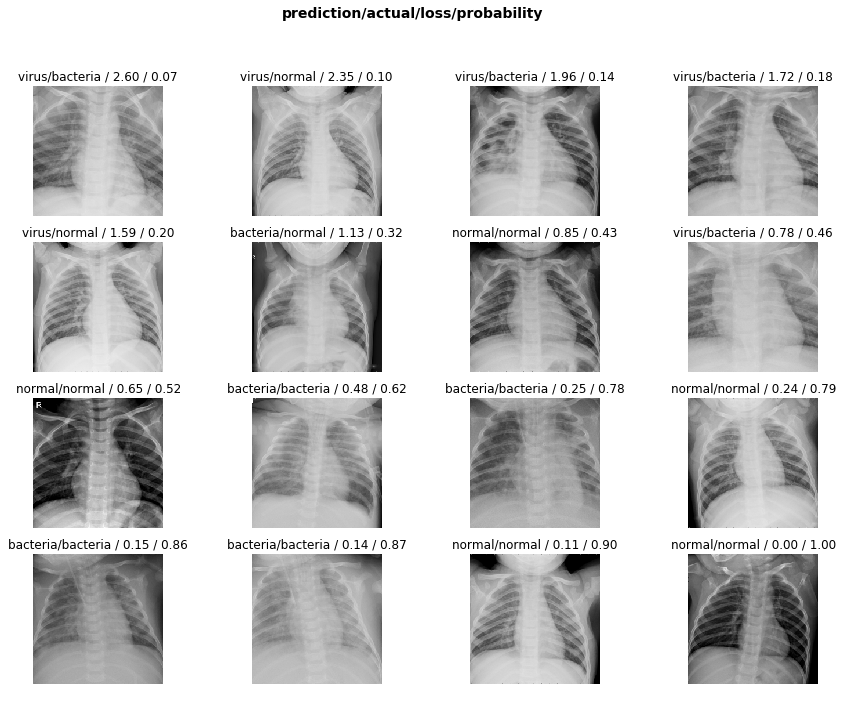

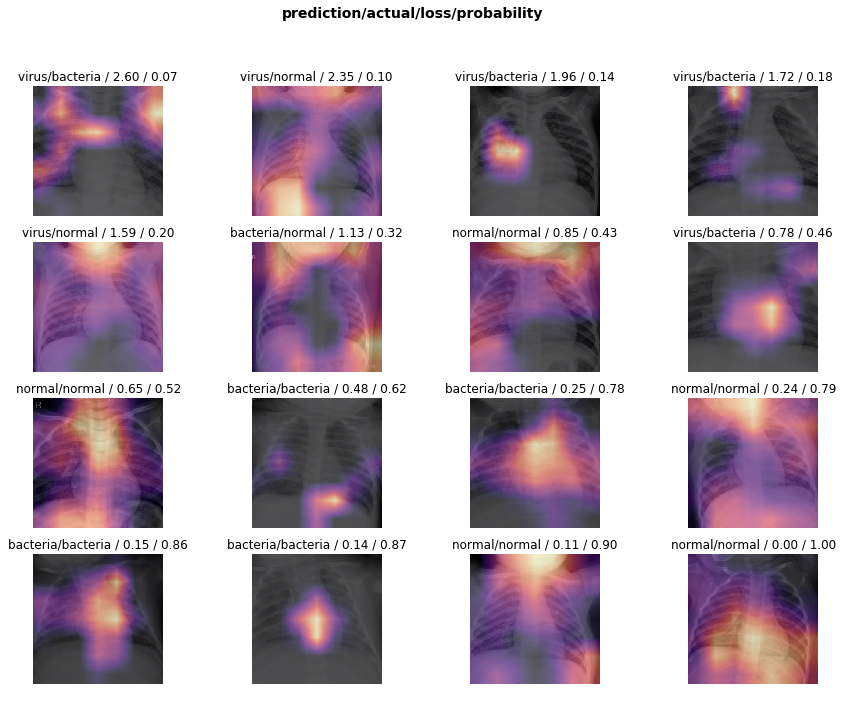

In [54]:
interp.plot_top_losses(16, figsize=(15,11), heatmap=False)
interp.plot_top_losses(16, figsize=(15,11))

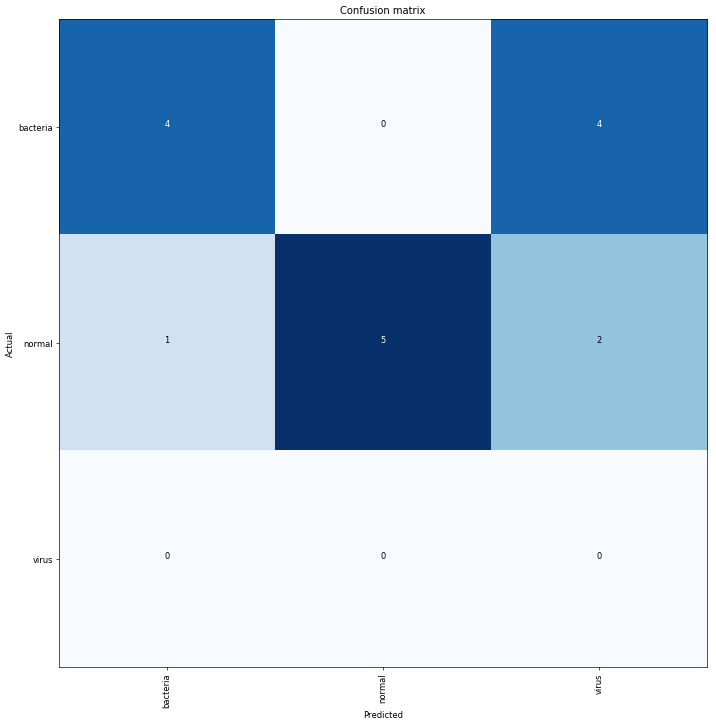

In [55]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [44]:
learn.unfreeze()

In [45]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.480913,0.659409,0.250000,00:57


In [56]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5216 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,normal
Path: /data0/chest_xray;

Valid: LabelList (16 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,normal
Path: /data0/chest_xray;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /data0/chest_xray, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
   

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


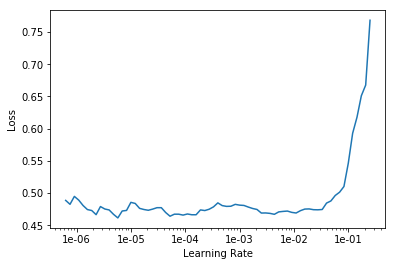

In [58]:
learn.recorder.plot()

In [59]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.470742,0.537105,0.187500,00:57
1,0.449201,0.721038,0.375000,00:57
2,0.398552,0.551691,0.250000,00:57
3,0.335213,0.514703,0.250000,00:57
4,0.259878,0.584349,0.187500,00:57


In [60]:
interp = ClassificationInterpretation.from_learner(learn)

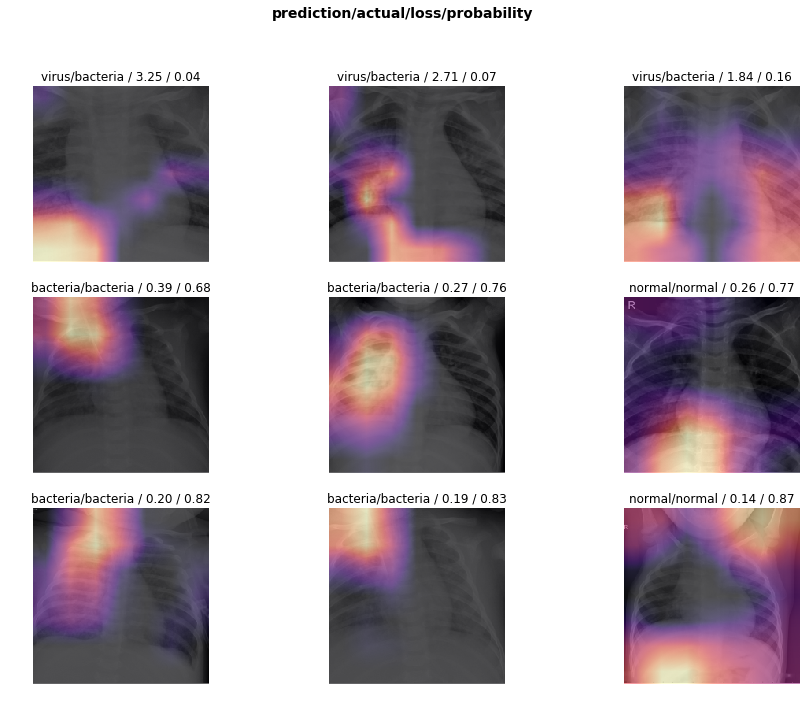

In [62]:
interp.plot_top_losses(9, figsize=(15,11))

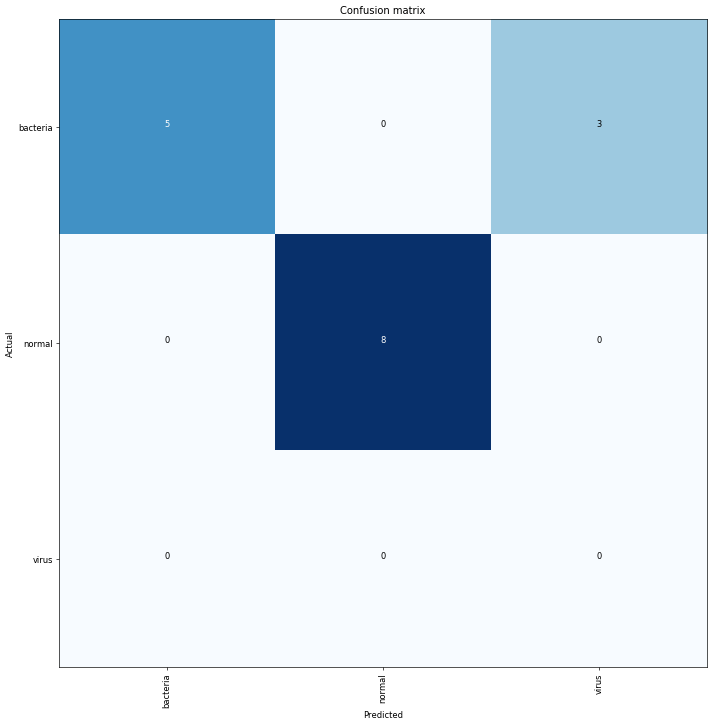

In [63]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)